In [150]:
%matplotlib inline

import numpy as np
import collections
from collections import OrderedDict, Counter, defaultdict
import pandas as pd

import Bio
from Bio import SeqIO
from Bio.Seq import Seq

import seaborn as sns
import matplotlib.pyplot as plt
from bokeh.plotting import figure, output_file, show 
import matplotlib.patches as patches    
from matplotlib import colors


import glob

import subprocess
from subprocess import call

import re

import pickle

from Bio.SubsMat import MatrixInfo
import Bio.Data.CodonTable

from scipy import stats


from Bio.SubsMat import MatrixInfo
import Bio.Data.CodonTable

import joypy

import pyBigWig

# Parse and slice multiple sequence alignment in fasta 

In [29]:
def get_aln(fasta_input):
    aln_col = []
    ids_li = []
    
    with open(fasta_input, 'r') as input_handle:
        for record in SeqIO.parse(input_handle, "fasta"):
            seq = str(record.seq)
            ids = str(record.id)
            aln_col.append([seq[i:i+1] for i in range(0, len(seq), 1)])
            ids_li.append(ids)
    return aln_col, ids_li

def re_index_with_gaps(aln_col):
    new_col_ind = []

    # take ref seq
    counter_pos = 0 # to exclude '-'

    for col in pd.DataFrame(aln_col).to_numpy()[0]:
        if (col == '-') | (col == '.'): # UCC UGA C = TCC TGA C
            new_col_ind.append(counter_pos)
        else: 
            counter_pos += 1
            new_col_ind.append(counter_pos)
    
    return new_col_ind


def slice_aln(aln_col, new_col_ind, a, b):
    fr_stop_motif_array = []
    for row in pd.DataFrame(aln_col).to_numpy():
        tmp = []
        for ind, col in zip(new_col_ind, row):
            if (ind >= a) & (ind <= b):
                tmp.append(col)
            
        fr_stop_motif_array.append(tmp)
    
    return fr_stop_motif_array


# Trips-plot: with ext part 

In [19]:
def prepare_data_for_trips2(meta, file_counts, metadata_pc_g25, 
                           tr_id, gene, l, p, fraq, cds, name, 
                           predicted_ext_start=False, figsize=(20, 10),
                           xlims='full', zeros=True, linew=9):
    
    f = pd.read_csv(file_counts)
    f.columns = ['Position', 'Sequence', 'Frame1', 'Frame2', 'Frame3', 'RNASeq']
    
    if f.iloc[0].Position == 1:
        f['Position'] = list(range(0, f.shape[0]))
    
    atgs_pos = {'frame_0':[], 'frame_1':[], 'frame_2':[]}
    stop_pos = {'frame_0':[], 'frame_1':[], 'frame_2':[]}

    for pos in f.Position.tolist():
        codon = ''.join(f.Sequence.tolist()[(pos-1):(pos-1+3)])
        if codon == 'ATG':
            if pos % 3 == 0:
                atgs_pos['frame_0'].append(pos)
            elif pos % 3 == 1:
                atgs_pos['frame_1'].append(pos)
            else:
                atgs_pos['frame_2'].append(pos)
            
        elif (codon == 'TGA') | (codon == 'TAA') | (codon == 'TAG'):
            if pos % 3 == 0:
                stop_pos['frame_0'].append(pos)
            elif pos % 3 == 1:
                stop_pos['frame_1'].append(pos)
            else:
                stop_pos['frame_2'].append(pos)
        else:
            continue     
            
    # add CDS borders
    cds_stop_pos = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_stop_pos
    cds_start_pos = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos + 1
    cds_start_codon = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_codon
    
    if xlims == 'ext':
        xlim1 = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1
        xlim2 = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].N_term_end1 + 50*3
    elif len(xlims) == 2:
        xlim1 = xlims[0]
        xlim2 = xlims[1]
    else: # full transcript
        xlim1 = 0
        xlim2 = len(metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].transcript_seq)
    
    d = {}
    
    d['cds_stop_pos'] = cds_stop_pos
    d['cds_start_pos'] = cds_start_pos
    d['cds_start_codon'] = cds_start_codon
    d['f'] = f
    d['stop_pos'] = stop_pos
    d['atgs_pos'] = atgs_pos
    d['xlims'] = (xlim1, xlim2)
    d['predicted_ext_start'] = predicted_ext_start
    d['l'] = l
    d['p'] = p
    d['figsize'] = figsize
    d['fraq'] = fraq
    d['cds'] = cds
    d['name'] = tr_id+'_'+gene
    d['zeros'] = zeros
    d['linew'] = linew
    
    return d


def trips_full2(d, name='test', font1=38, font2=45):
    
    l = d['l']
    p = d['p']
    f = d['f'] # dict with frames 
    atgs_pos = d['atgs_pos']
    stop_pos = d['stop_pos']
    cds_start_pos = d['cds_start_pos']
    cds_stop_pos = d['cds_stop_pos']
    figsize = d['figsize']
    xlims = d['xlims']
    fraq = d['fraq']
    cds = d['cds']
    name = d['name']
    zeros = d['zeros']
    linewidth = d['linew'] 
    
    fig, axes = plt.subplots(5, 1, figsize = figsize, 
                             gridspec_kw={'height_ratios':[10,1.5,1,1,1]}, sharex=True, sharey=False, )

    main_plot = axes[0]
    #cds = axes[1]
    orfs = axes[1]
    red = axes[2]
    green = axes[3]
    blue = axes[4]

    # x 
    main_plot.set_xlim(f.Position.min(), f.Position.max()+1)

    # y
    
    if xlims is not False:
        f1 = f[xlims[0]:xlims[1]]
        max_height = np.max([np.max(f1.Frame1.tolist()), np.max(f1.Frame2.tolist()), np.max(f1.Frame3.tolist())])
        print (max_height)
    else:
        max_height = np.max([np.max(f.Frame1.tolist()), np.max(f.Frame2.tolist()), np.max(f.Frame3.tolist())])
        print (max_height)
        
    #### ????? why they dissappear????? ######    
    main_plot.set_ylim(0, max_height+max_height/l)
    main_plot.set_yticks(np.arange(0, max_height+max_height/l, p))
    main_plot.set_yticklabels(np.arange(0, max_height+max_height/l, p, dtype=np.int64), fontsize=font1)
    
    # print (f[125:150])

    # #frame 1 = red, frame2 = green, frame3 = blue
    if zeros == True:
        main_plot.plot(f.Frame1.tolist(), color = 'crimson', linewidth=linewidth, linestyle='-')
        main_plot.plot(f.Frame2.tolist(), color = 'goldenrod', linewidth=linewidth, linestyle='-')
        main_plot.plot(f.Frame3.tolist(), color = 'darkblue', linewidth=linewidth, linestyle='-')
    
    else:
        # delete zeros 
        t = f[['Position', 'Frame1']]
        fr1 = t[t['Frame1'] != 0]
        
        t = f[['Position', 'Frame2']]
        fr2 = t[t['Frame2'] != 0]
        
        t = f[['Position', 'Frame3']]
        fr3 = t[t['Frame3'] != 0]
        
        main_plot.plot(fr1.Position.tolist(), fr1.Frame1.tolist(), color = 'crimson', linewidth=linewidth, linestyle='-')
        main_plot.plot(fr2.Position.tolist(), fr2.Frame2.tolist(), color = 'goldenrod', linewidth=linewidth, linestyle='-')
        main_plot.plot(fr3.Position.tolist(), fr3.Frame3.tolist(), color = 'darkblue', linewidth=linewidth, linestyle='-')
    
     
    red.set_facecolor('crimson')
    green.set_facecolor('goldenrod')
    blue.set_facecolor('darkblue')
    #cds.set_facecolor('lightgrey')

    #blue.set_xticks(np.arange(0, f.Position.max(), 50))
    #blue.set_xticklabels(np.arange(0, f.Position.max(), 50), fontsize=45)

    red.set_yticklabels(())
    green.set_yticklabels(())
    blue.set_yticklabels(())
    #cds.set_yticklabels(())
    orfs.set_yticklabels(())
    
    

    blue.set_ylabel('f2', fontsize=font1)#, rotation = 0)
    red.set_ylabel('f0', fontsize=font1)#, rotation = 0)
    green.set_ylabel('f1', fontsize=font1)#, rotation = 0)
    #cds.set_ylabel('cds', fontsize=35)#, rotation = 0)
    orfs.set_ylabel('orf', fontsize=font1)#, rotation = 0)

    for frame, pos_li in atgs_pos.items():
        if frame == 'frame_0':
            for pos in pos_li:
                blue.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
        elif frame == 'frame_1':
            for pos in pos_li:
                red.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
        else:
            for pos in pos_li:
                green.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
            
    for frame, pos_li in stop_pos.items():
        if frame == 'frame_0':
            for pos in pos_li:
                blue.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
        elif frame == 'frame_1':
            for pos in pos_li:
                red.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
        else:
            for pos in pos_li:
                green.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
            
                    
    # add start of annotated CDS
    main_plot.vlines(cds_stop_pos, ymin=0, ymax=max_height+max_height/l, colors='black', linewidth=linewidth-2)
    main_plot.vlines(cds_start_pos, ymin=0, ymax=max_height+max_height/l, colors='black', linewidth=linewidth-2)
    #main_plot.text(x = cds_stop_pos-100, y = max_height+max_height/10, s = 'cds stop', fontsize=39)
    #main_plot.text(x = cds_start_pos-10, y = max_height+0.1, s = 'cds start', fontsize=39)


    # add rectangle = CDS
    #if cds is True:
        #rect = patches.Rectangle((cds_start_pos, 0),cds_stop_pos-cds_start_pos,
                         #1,linewidth=1,edgecolor='r',facecolor='lightgrey')
        #cds.add_patch(rect)

        # add non-AUG - cds_start_pos
        #cds.text(x = cds_start_pos, y = 0.3, s = 'AUG', fontsize=38)
    print ('NAME:', name)
    
    # add rectangle = extended CDS
    xlims = d['xlims']
    predicted_ext_start = d['predicted_ext_start']
    if xlims is not False:
        if predicted_ext_start is not False:
            Nst = int(predicted_ext_start.split('_')[0])
            codon_name = predicted_ext_start.split('_')[1]
            N2 = cds_stop_pos
            
            if name != 'ENST00000381140_GTF3A':
                rect = patches.Rectangle((Nst, 0), N2-Nst,1,linewidth=1,edgecolor='r',facecolor='silver')
                orfs.add_patch(rect)
        
                orfs.text(x = Nst, y = 0.3, s = codon_name, fontsize=font1)
            
            else:
                print ('!!!')
                N2 = 330#stop codon of overlapping out-of-frame ORF 
                rect = patches.Rectangle((Nst, 0), N2-Nst,1,linewidth=1,edgecolor='b',facecolor='silver')
                orfs.add_patch(rect)
        
                orfs.text(x = Nst, y = 0.3, s = codon_name, fontsize=font1)
                

    
    blue.set_xticks(range(f.Position.min(), f.Position.max()+1, fraq))       
    blue.set_xticklabels(range(f.Position.min(), f.Position.max()+1, fraq), fontsize=font1)
    
    print (f.Position.min())
    
    
    if xlims is not False:    
        plt.xlim(xlims[0], xlims[1])
        
        
    main_plot.set_title(name, fontsize=font2)
    plt.subplots_adjust(left=0.1, bottom=0.1,
                    wspace=0.1, hspace=0.1)
    
    plt.savefig('tmp_res/plots/'+name+'.png', dpi = 300, bbox_inches = 'tight')
    

# Trips-plot withouth ext 

In [51]:
def trips_full_no_ORF(d, name='test', font1=38, font2=45):
    
    l = d['l']
    p = d['p']
    f = d['f'] # dict with frames 
    atgs_pos = d['atgs_pos']
    stop_pos = d['stop_pos']
    cds_start_pos = d['cds_start_pos']
    cds_stop_pos = d['cds_stop_pos']
    figsize = d['figsize']
    xlims = d['xlims']
    fraq = d['fraq']
    cds = d['cds']
    name = d['name']
    zeros = d['zeros']
    linewidth = d['linew'] 
    
    fig, axes = plt.subplots(4, 1, figsize = figsize, 
                             gridspec_kw={'height_ratios':[10,1,1,1]}, sharex=True, sharey=False, )

    main_plot = axes[0]
    red = axes[1]
    green = axes[2]
    blue = axes[3]

    # x 
    main_plot.set_xlim(f.Position.min(), f.Position.max()+1)

    # y
    
    if xlims is not False:
        f1 = f[xlims[0]:xlims[1]]
        max_height = np.max([np.max(f1.Frame1.tolist()), np.max(f1.Frame2.tolist()), np.max(f1.Frame3.tolist())])
        print (max_height)
    else:
        max_height = np.max([np.max(f.Frame1.tolist()), np.max(f.Frame2.tolist()), np.max(f.Frame3.tolist())])
        print (max_height)
        
    #### ????? why they dissappear????? ######    
    main_plot.set_ylim(0, max_height+max_height/l)
    main_plot.set_yticks(np.arange(0, max_height+max_height/l, p))
    main_plot.set_yticklabels(np.arange(0, max_height+max_height/l, p, dtype=np.int64), fontsize=font1)
    
    # print (f[125:150])

    # #frame 1 = red, frame2 = green, frame3 = blue
    if zeros == True:
        main_plot.plot(f.Frame1.tolist(), color = 'crimson', linewidth=linewidth, linestyle='-')
        main_plot.plot(f.Frame2.tolist(), color = 'goldenrod', linewidth=linewidth, linestyle='-')
        main_plot.plot(f.Frame3.tolist(), color = 'darkblue', linewidth=linewidth, linestyle='-')
    
    else:
        # delete zeros 
        t = f[['Position', 'Frame1']]
        fr1 = t[t['Frame1'] != 0]
        
        t = f[['Position', 'Frame2']]
        fr2 = t[t['Frame2'] != 0]
        
        t = f[['Position', 'Frame3']]
        fr3 = t[t['Frame3'] != 0]
        
        main_plot.plot(fr1.Position.tolist(), fr1.Frame1.tolist(), color = 'crimson', linewidth=linewidth, linestyle='-')
        main_plot.plot(fr2.Position.tolist(), fr2.Frame2.tolist(), color = 'goldenrod', linewidth=linewidth, linestyle='-')
        main_plot.plot(fr3.Position.tolist(), fr3.Frame3.tolist(), color = 'darkblue', linewidth=linewidth, linestyle='-')
    
     
    red.set_facecolor('crimson')
    green.set_facecolor('goldenrod')
    blue.set_facecolor('darkblue')
    #cds.set_facecolor('lightgrey')

    #blue.set_xticks(np.arange(0, f.Position.max(), 50))
    #blue.set_xticklabels(np.arange(0, f.Position.max(), 50), fontsize=45)

    red.set_yticklabels(())
    green.set_yticklabels(())
    blue.set_yticklabels(())
    #cds.set_yticklabels(())
    #orfs.set_yticklabels(())
    
    

    blue.set_ylabel('f2', fontsize=font1)#, rotation = 0)
    red.set_ylabel('f0', fontsize=font1)#, rotation = 0)
    green.set_ylabel('f1', fontsize=font1)#, rotation = 0)
    #cds.set_ylabel('cds', fontsize=35)#, rotation = 0)
    #orfs.set_ylabel('orf', fontsize=font1)#, rotation = 0)

    for frame, pos_li in atgs_pos.items():
        if frame == 'frame_0':
            for pos in pos_li:
                blue.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
        elif frame == 'frame_1':
            for pos in pos_li:
                red.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
        else:
            for pos in pos_li:
                green.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
            
    for frame, pos_li in stop_pos.items():
        if frame == 'frame_0':
            for pos in pos_li:
                blue.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
        elif frame == 'frame_1':
            for pos in pos_li:
                red.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
        else:
            for pos in pos_li:
                green.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
            
                    
    # add start of annotated CDS
    main_plot.vlines(cds_stop_pos, ymin=0, ymax=max_height+max_height/l, colors='black', linewidth=linewidth-2)
    main_plot.vlines(cds_start_pos, ymin=0, ymax=max_height+max_height/l, colors='black', linewidth=linewidth-2)
    #main_plot.text(x = cds_stop_pos-100, y = max_height+max_height/10, s = 'cds stop', fontsize=39)
    #main_plot.text(x = cds_start_pos-10, y = max_height+0.1, s = 'cds start', fontsize=39)


    # add rectangle = CDS
    #if cds is True:
        #rect = patches.Rectangle((cds_start_pos, 0),cds_stop_pos-cds_start_pos,
                         #1,linewidth=1,edgecolor='r',facecolor='lightgrey')
        #cds.add_patch(rect)

        # add non-AUG - cds_start_pos
        #cds.text(x = cds_start_pos, y = 0.3, s = 'AUG', fontsize=38)
    print ('NAME:', name)
    
    # add rectangle = extended CDS
    xlims = d['xlims']
    predicted_ext_start = d['predicted_ext_start']
    if xlims is not False:
        if predicted_ext_start is not False:
            Nst = int(predicted_ext_start.split('_')[0])
            codon_name = predicted_ext_start.split('_')[1]
            N2 = cds_stop_pos
            
            if name != 'ENST00000381140_GTF3A':
                rect = patches.Rectangle((Nst, 0), N2-Nst,1,linewidth=1,edgecolor='r',facecolor='silver')
                #orfs.add_patch(rect)
        
                #orfs.text(x = Nst, y = 0.3, s = codon_name, fontsize=font1)
            
            else:
                print ('!!!')
                N2 = 330#stop codon of overlapping out-of-frame ORF 
                rect = patches.Rectangle((Nst, 0), N2-Nst,1,linewidth=1,edgecolor='b',facecolor='silver')
                #orfs.add_patch(rect)
        
                #orfs.text(x = Nst, y = 0.3, s = codon_name, fontsize=font1)
                

    
    blue.set_xticks(range(f.Position.min(), f.Position.max()+1, fraq))       
    blue.set_xticklabels(range(f.Position.min(), f.Position.max()+1, fraq), fontsize=font1)
    
    print (f.Position.min())
    
    
    if xlims is not False:    
        plt.xlim(xlims[0], xlims[1])
        
        
    main_plot.set_title(name, fontsize=font2)
    plt.subplots_adjust(left=0.1, bottom=0.1,
                    wspace=0.1, hspace=0.1)
    
    plt.savefig('tmp_res/plots/'+name+'.png', dpi = 300, bbox_inches = 'tight')
    

# Metadata 

In [15]:
path = '/home/alla/make_PhD_great_again/NTE/VERSION_since_May2021/'

# gencode 25
metadata_pc_g25 = pd.read_csv(path+'tmp_res/metadata_pc_g25.txt', sep='\t')
metadata_pc_g25['tr_id1'] = [x.split('.')[0] for x in metadata_pc_g25['tr_id'].tolist()] 

In [132]:
# open metadata with scores and metrics
meta = pd.read_csv('/home/alla/make_PhD_great_again/NTE/VERSION_since_May2021/tmp_res/METADATA_CURRENT.txt', sep='\t')


meta[0:2]

,tr_id,N_term_start,N_term_end,len,N_term_start1,N_term_end1,len_codons,gene,50len_flag,global_coo_50_and_less,...,gene_ext,Start_ext,Stop_ext,global_rank_ext,Start_codon_ext,Proteomics_count_ext,Coverage_value_ext,CDS_ratio,Riboseq_Summary,Nstart_Nend
0,ENST00000624431.1,274,316,42,274,316,14.0,FO538757.2,274,chr1:182667-182708,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,274-316
1,ENST00000624735.1,0,236,236,2,236,78.0,FO538757.1,86,chr1:200087-200236,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2-236


# Predicted with Trips-viz non-AUG extended proteoforms 

In [21]:
transl_with_all_codons = pd.read_csv(path+'data/extensions_TripsViz_1perGene_AUG_NearCognates.txt', sep=',')

transl_with_all_codons.columns = ['gene', 'tr_id1', 'Start_ext', 'Stop_ext', 'len_ext', 
                                 'global_rank_ext', 'type_all_codons', 'trips_viz_link', 'Start_codon_ext', 
                                 'Highframe rank', 'Highframe value',
       'Lowframe rank', 'Lowframe value', 'Stop rank', 'Stop value',
       'Start rank', 'Start value', 'Coverage rank', 'Coverage_value_ext',
       'Amino acid sequence', 'Proteomics_count_ext', 'CDS_ratio']

transl_with_all_codons2 = transl_with_all_codons[['gene', 'tr_id1', 'Start_ext', 'Stop_ext', 
                                                 'global_rank_ext', 'Start_codon_ext', 
                                                 'Proteomics_count_ext', 'Coverage_value_ext', 'CDS_ratio']]

transl_with_all_codons2['Riboseq_Summary'] = transl_with_all_codons2['Start_codon_ext']+'; '+transl_with_all_codons2['Start_ext'].astype(str)+'-'+transl_with_all_codons2['Stop_ext'].astype(str)+'; Rank: '+transl_with_all_codons2['global_rank_ext'].astype(str)+'; cov: '+np.round(transl_with_all_codons2['Coverage_value_ext'],2).astype(str)



print (transl_with_all_codons2.shape[0])
transl_with_all_codons2[0:5]

10471


/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,gene,tr_id1,Start_ext,Stop_ext,global_rank_ext,Start_codon_ext,Proteomics_count_ext,Coverage_value_ext,CDS_ratio,Riboseq_Summary
0,ASPH,ENST00000379454,144,189,1,CTG,0.0,100.000000,1.645069,CTG; 144-189; Rank: 1; cov: 100.0
1,HSP90AA1,ENST00000216281,168,207,2,GTG,0.0,100.000000,3.081078,GTG; 168-207; Rank: 2; cov: 100.0
2,CD24,ENST00000619133,408,441,3,CTG,0.0,83.333333,11.578498,CTG; 408-441; Rank: 3; cov: 83.33
3,HN1,ENST00000409753,242,287,4,TTG,0.0,100.000000,0.588389,TTG; 242-287; Rank: 4; cov: 100.0
4,YBX1,ENST00000321358,44,140,5,CTG,0.0,85.185185,7.709763,CTG; 44-140; Rank: 5; cov: 85.19


In [22]:
master_df2 = metadata_pc_g25[~metadata_pc_g25['tr_id'].str.contains('PAR')][['tr_id', 'tr_id1', 'cds_start_pos', 'cds_stop_pos']].merge(transl_with_all_codons2,
                                                                                        on='tr_id1', 
                                                                                                                                        how='inner')

# No ovlps with G25/39/REFSEQ (4449)

In [98]:
ovlp = pd.read_csv('/home/alla/make_PhD_great_again/SNPS_in_NTE/GATK_CodALignVIew_McDonald_Kreitman/tmp_res/master_df_top5000_ext_no_ovlps_g25_39_refseq.txt', sep='\t')
ovlp['tr_id1'] = [x.split('.')[0] for x in ovlp['tr_id'].tolist()]

print (ovlp.shape[0])

ovlp[0:3]

4449


,tr_id,strand,global_coo,tr_id1,gene,pos_of_codon,cds_start_pos,chr,Start_ext,Stop_ext,global_rank_ext,Start_codon_ext,Proteomics_count_ext,Coverage_value_ext,CDS_ratio,Riboseq_Summary
0,ENST00000001146.6,-,chr2:72147835-72147954,ENST00000001146,CYP26B1,84,204,chr2,85,205,3888,CTG,0.0,11.428571,0.0,CTG; 85-205; Rank: 3888; cov: 11.43
1,ENST00000003084.10,+,chr7:117480044-117480094,ENST00000003084,CFTR,81,132,chr7,82,133,3401,AGG,0.0,16.666667,0.0,AGG; 82-133; Rank: 3401; cov: 16.67
2,ENST00000003302.8,-,chr11:113875502-113875561,ENST00000003302,USP28,9,69,chr11,10,70,2063,AGG,0.0,40.000000,0.0,AGG; 10-70; Rank: 2063; cov: 40.0


In [99]:
master_df3 = master_df2.merge(ovlp[['tr_id', 'tr_id1', 'strand', 'global_coo']], on=['tr_id1', 'tr_id'], how='inner')

print (master_df3.shape[0])

master_df3[0:2]

4449


,tr_id,tr_id1,cds_start_pos,cds_stop_pos,gene,Start_ext,Stop_ext,global_rank_ext,Start_codon_ext,Proteomics_count_ext,Coverage_value_ext,CDS_ratio,Riboseq_Summary,strand,global_coo
0,ENST00000327044.6,ENST00000327044,50,2300,NOC2L,12,51,1331,CTG,0.0,62.500000,0.172278,CTG; 12-51; Rank: 1331; cov: 62.5,-,chr1:959241-959279
1,ENST00000379389.4,ENST00000379389,151,649,ISG15,98,152,288,ATC,0.0,53.846154,0.327240,ATC; 98-152; Rank: 288; cov: 53.85,+,chr1:1013520-1013573


In [133]:
master_df4 = master_df3.merge(meta[['tr_id', 'N_term_start1', 'N_term_end1', 'global_coo_primary', 'strand']],
                             on='tr_id', how='inner')

print (master_df4.shape)

master_df4[0:4]

(4449, 19)


,tr_id,tr_id1,cds_start_pos,cds_stop_pos,gene,Start_ext,Stop_ext,global_rank_ext,Start_codon_ext,Proteomics_count_ext,Coverage_value_ext,CDS_ratio,Riboseq_Summary,strand_x,global_coo,N_term_start1,N_term_end1,global_coo_primary,strand_y
0,ENST00000327044.6,ENST00000327044,50,2300,NOC2L,12,51,1331,CTG,0.0,62.500000,0.172278,CTG; 12-51; Rank: 1331; cov: 62.5,-,chr1:959241-959279,2,50,chr1:959241-959288,-
1,ENST00000379389.4,ENST00000379389,151,649,ISG15,98,152,288,ATC,0.0,53.846154,0.327240,ATC; 98-152; Rank: 288; cov: 53.85,+,chr1:1013520-1013573,1,151,chr1:1013424-1013573,+
2,ENST00000349431.10,ENST00000349431,220,1000,UBE2J2,173,221,328,ACG,0.0,90.909091,0.762814,ACG; 173-221; Rank: 328; cov: 90.91,-,chr1:1273666-1273713,28,220,chr1:1273666-1273857,-
3,ENST00000354700.9,ENST00000354700,203,2708,ACAP3,174,204,1072,GTG,0.0,80.000000,0.000000,GTG; 174-204; Rank: 1072; cov: 80.0,-,chr1:1307816-1307845,32,203,chr1:1307816-1307986,-


# TIS scores for nonAUG 

In [28]:
TIS_efficiency_df = pd.read_csv('/home/alla/make_PhD_great_again/NTE/VERSION_since_May2021/data/TIS_nonAUG_efficiency.txt', sep='\t')

TIS_efficiency_df['scaled_efficiency'] = TIS_efficiency_df['TIS Efficiency'] / TIS_efficiency_df['TIS Efficiency'].max()

TIS_efficiency_dict = dict(zip(TIS_efficiency_df['TIS Sequence'], TIS_efficiency_df['TIS Efficiency']))

TIS_efficiency_dict_scaled = dict(zip(TIS_efficiency_df['TIS Sequence'], TIS_efficiency_df['scaled_efficiency']))

TIS_efficiency_df.sort_values(by='TIS Efficiency', ascending=False).head(4)

,TIS Sequence,TIS Efficiency,scaled_efficiency
5977,CGCCCUGG,50.4,1.000000
6041,CGCGCUGG,50.4,1.000000
5913,CGCACUGG,50.4,1.000000
6001,CAUCCUGG,47.6,0.944444


In [92]:
TIS_AUG_eff = pd.read_csv('/home/alla/make_PhD_great_again/NTE/VERSION_since_May2021/data/TIS_AUG_efficiency.txt',
                          sep='\t')
                           
TIS_AUG_eff[0:5]

,sequence,efficiency,lower.bound,upper.bound
0,UUCAUCAUGCA,150,139,161
1,GCGAGUAUGGC,149,139,161
2,ACGAGAAUGGC,148,136,160
3,AUCAUCAUGCA,147,136,158
4,ACGAGUAUGGC,145,134,157


# Example of plot 

146
NAME: ENST00000307522_CCDC8
0


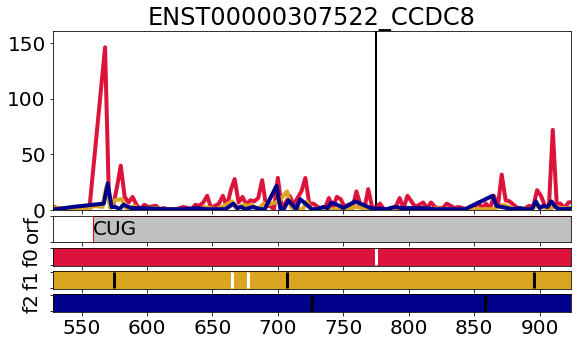

In [25]:
gene = 'CCDC8'

tr_id = 'ENST00000307522'


#pred_start = master_df2[master_df2['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
#pos_pred_start = master_df2[master_df2['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 


pre_st = pos_pred_start + '_' + 'CUG'

xlims = [master_df2[master_df2['tr_id'].str.contains(tr_id)].iloc[0].Start_ext-1-30, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*3]

d1 = prepare_data_for_trips2(meta = metadata_pc_g25, 
                           file_counts = 'data/Tripslike_plots_data/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =50, 
                             fraq = 50, 
                             cds = False,
                             name = 'CCDC8.png',
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = 'CCDC8_mccmb.png', font1=20, font2=24)

# Known gene with exclusive non-AUG initiation 

2114
NAME: ENST00000381140_GTF3A
!!!
0


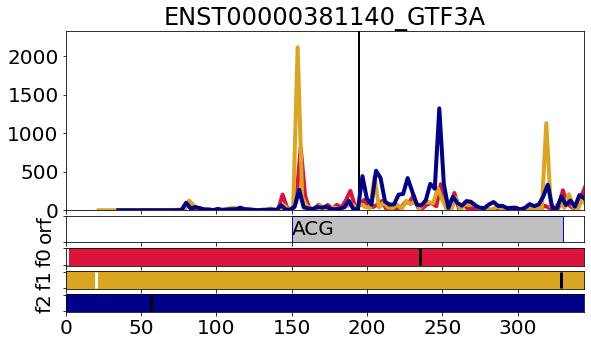

In [26]:
gene = 'GTF3A'

tr_id = 'ENST00000381140'


#pred_start = master_df2[master_df2['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
#pos_pred_start = master_df2[master_df2['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 


#pre_st = pos_pred_start + '_' + pred_start

pre_st = '150_ACG'

xlims = [0, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*3]

d1 = prepare_data_for_trips2(meta = metadata_pc_g25, 
                           file_counts = 'data/Tripslike_plots_data/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id,                 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =500, 
                             fraq = 50, 
                             cds = False,
                             name = 'GTF3A.png', 
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False
                           )

trips_full2(d1, name = 'GTF3A.png', font1=20, font2=24)

In [30]:
TIS_efficiency_df[TIS_efficiency_df['TIS Sequence'] == 'CGCCCUGG'] 

,TIS Sequence,TIS Efficiency,scaled_efficiency
5977,CGCCCUGG,50.4,1.0


In [38]:
tr_id = 'ENST00000381140.8'

tr_seq = metadata_pc_g25[metadata_pc_g25['tr_id'] == tr_id].iloc[0].transcript_seq
cds_start_pos = metadata_pc_g25[metadata_pc_g25['tr_id'] == tr_id].iloc[0].cds_start_pos
cds_stop_pos = metadata_pc_g25[metadata_pc_g25['tr_id'] == tr_id].iloc[0].cds_stop_pos
TIS_seq = tr_seq[cds_start_pos-4:cds_start_pos+4].replace("T", 'U')


print ('cds_start:', cds_start_pos, 'cds_stop:', cds_stop_pos)

print ('TIS sequence:', TIS_seq)
print ('TIS score:', TIS_efficiency_df[TIS_efficiency_df['TIS Sequence'] == TIS_seq].iloc[0]['TIS Efficiency'])

cds_start: 194 cds_stop: 1292
TIS sequence: CGCCCUGG
TIS score: 50.4


In [41]:
print ('CDS aa sequence:', str(Seq(tr_seq[cds_start_pos:cds_stop_pos]).translate()))

CDS aa sequence: LDPPAVVAESVSSLTIADAFIAAGESSAPTPPRPALPRRFICSFPDCSANYSKAWKLDAHLCKHTGERPFVCDYEGCGKAFIRDYHLSRHILTHTGEKPFVCAANGCDQKFNTKSNLKKHFERKHENQQKQYICSFEDCKKTFKKHQQLKIHQCQHTNEPLFKCTQEGCGKHFASPSKLKRHAKAHEGYVCQKGCSFVAKTWTELLKHVRETHKEEILCEVCRKTFKRKDYLKQHMKTHAPERDVCRCPREGCGRTYTTVFNLQSHILSFHEESRPFVCEHAGCGKTFAMKQSLTRHAVVHDPDKKKMKLKVKKSREKRSLASHLSGYIPPKRKQGQGLSLCQNGESPNCVEDKMLSTVAVLTLG*


# TRPV6

In [42]:
tr_id = 'ENST00000359396.7'

tr_seq = metadata_pc_g25[metadata_pc_g25['tr_id'] == tr_id].iloc[0].transcript_seq
cds_start_pos = metadata_pc_g25[metadata_pc_g25['tr_id'] == tr_id].iloc[0].cds_start_pos
cds_stop_pos = metadata_pc_g25[metadata_pc_g25['tr_id'] == tr_id].iloc[0].cds_stop_pos
TIS_seq = tr_seq[cds_start_pos-4:cds_start_pos+4].replace("T", 'U')


print ('cds_start:', cds_start_pos, 'cds_stop:', cds_stop_pos)

print ('TIS sequence:', TIS_seq)
print ('TIS score:', TIS_efficiency_df[TIS_efficiency_df['TIS Sequence'] == TIS_seq].iloc[0]['TIS Efficiency'])

cds_start: 126 cds_stop: 2424
TIS sequence: GGAGACGG
TIS score: 4.1


In [43]:
print ('CDS aa sequence:', str(Seq(tr_seq[cds_start_pos:cds_stop_pos]).translate()))

CDS aa sequence: TGPLQGDGGPALGGADVAPRLSPVRVWPRPQAPKEPALHPMGLSLPKEKGLILCLWSKFCRWFQRRESWAQSRDEQNLLQQKRIWESPLLLAAKDNDVQALNKLLKYEDCKVHQRGAMGETALHIAALYDNLEAAMVLMEAAPELVFEPMTSELYEGQTALHIAVVNQNMNLVRALLARRASVSARATGTAFRRSPCNLIYFGEHPLSFAACVNSEEIVRLLIEHGADIRAQDSLGNTVLHILILQPNKTFACQMYNLLLSYDRHGDHLQPLDLVPNHQGLTPFKLAGVEGNTVMFQHLMQKRKHTQWTYGPLTSTLYDLTEIDSSGDEQSLLELIITTKKREARQILDQTPVKELVSLKWKRYGRPYFCMLGAIYLLYIICFTMCCIYRPLKPRTNNRTSPRDNTLLQQKLLQEAYMTPKDDIRLVGELVTVIGAIIILLVEVPDIFRMGVTRFFGQTILGGPFHVLIITYAFMVLVTMVMRLISASGEVVPMSFALVLGWCNVMYFARGFQMLGPFTIMIQKMIFGDLMRFCWLMAVVILGFASAFYIIFQTEDPEELGHFYDYPMALFSTFELFLTIIDGPANYNVDLPFMYSITYAAFAIIATLLMLNLLIAMMGDTHWRVAHERDELWRAQIVATTVMLERKLPRCLWPRSGICGREYGLGDRWFLRVEDRQDLNRQRIQRYAQAFHTRGSEDLDKDSVEKLELGCPFSPHLSLPMPSVSRSTSRSSANWERLRQGTLRRDLRGIINRGLEDGESWEYQI*


# EIF4G2

In [45]:
tr_id = 'ENST00000526148.5'

tr_seq = metadata_pc_g25[metadata_pc_g25['tr_id'] == tr_id].iloc[0].transcript_seq
cds_start_pos = metadata_pc_g25[metadata_pc_g25['tr_id'] == tr_id].iloc[0].cds_start_pos
cds_stop_pos = metadata_pc_g25[metadata_pc_g25['tr_id'] == tr_id].iloc[0].cds_stop_pos
TIS_seq = tr_seq[cds_start_pos-4:cds_start_pos+4].replace("T", 'U')


print ('cds_start:', cds_start_pos, 'cds_stop:', cds_stop_pos)

print ('TIS sequence:', TIS_seq)
print ('TIS score:', TIS_efficiency_df[TIS_efficiency_df['TIS Sequence'] == TIS_seq].iloc[0]['TIS Efficiency'])

cds_start: 511 cds_stop: 3235
TIS sequence: CAAAGUGG
TIS score: 8.7


In [46]:
print ('CDS aa sequence:', str(Seq(tr_seq[cds_start_pos:cds_stop_pos]).translate()))

CDS aa sequence: VESAIAEGGASRFSASSGGGGSRGAPQHYPKTAGNSEFLGKTPGQNAQKWIPARSTRRDDNSAANNSANEKERHDAIFRKVRGILNKLTPEKFDKLCLELLNVGVESKLILKGVILLIVDKALEEPKYSSLYAQLCLRLAEDAPNFDGPAAEGQPGQKQSTTFRRLLISKLQDEFENRTRNVDVYDKRENPLLPEEEEQRAIAKIKMLGNIKFIGELGKLDLIHESILHKCIKTLLEKKKRVQLKDMGEDLECLCQIMRTVGPRLDHERAKSLMDQYFARMCSLMLSKELPARIRFLLQDTVELREHHWVPRKAFLDNGPKTINQIRQDAVKDLGVFIPAPMAQGMRSDFFLEGPFMPPRMKMDRDPLGGLADMFGQMPGSGIGTGPGVIQDRFSPTMGRHRSNQLFNGHGGHIMPPTQSQFGEMGGKFMKSQGLSQLYHNQSQGLLSQLQGQSKDMPPRFSKKGQLNADEISLRPAQSFLMNKNQVPKLQPQITMIPPSAQPPRTQTPPLGQTPQLGLKTNPPLIQEKPAKTSKKPPPSKEELLKLTETVVTEYLNSGNANEAVNGVREMRAPKHFLPEMLSKVIILSLDRSDEDKEKASSLISLLKQEGIATSDNFMQAFLNVLDQCPKLEVDIPLVKSYLAQFAARAIISELVSISELAQPLESGTHFPLFLLCLQQLAKLQDREWLTELFQQSKVNMQKMLPEIDQNKDRMLEILEGKGLSFLFPLLKLEKELLKQIKLDPSPQTIYKWIKDNISPKLHVDKGFVNILMTSFLQYISSEVNPPSDETDSSSAPSKEQLEQEKQLLLSFKPVMQKFLHDHVDLQVSALYALQVHCYNSNFPKGMLLRFFVHFYDMEIIEEEAFLAWKEDITQEFPGKGKALFQVNQWLTWLETAEEEESEEEAD*


# TEAD1

In [48]:
tr_id = 'ENST00000527636.5'

tr_seq = metadata_pc_g25[metadata_pc_g25['tr_id'] == tr_id].iloc[0].transcript_seq
cds_start_pos = metadata_pc_g25[metadata_pc_g25['tr_id'] == tr_id].iloc[0].cds_start_pos
cds_stop_pos = metadata_pc_g25[metadata_pc_g25['tr_id'] == tr_id].iloc[0].cds_stop_pos
TIS_seq = tr_seq[cds_start_pos-4:cds_start_pos+4].replace("T", 'U')


print ('cds_start:', cds_start_pos, 'cds_stop:', cds_stop_pos)

print ('TIS sequence:', TIS_seq)
print ('TIS score:', TIS_efficiency_df[TIS_efficiency_df['TIS Sequence'] == TIS_seq].iloc[0]['TIS Efficiency'])

cds_start: 451 cds_stop: 1732
TIS sequence: CAAAAUUG
TIS score: 6.1


In [49]:
print ('CDS aa sequence:', str(Seq(tr_seq[cds_start_pos:cds_stop_pos]).translate()))

CDS aa sequence: IEPSSWSGSESPAENMERMSDSADKPIDNDAEGVWSPDIEQSFQEALAIYPPCGRRKIILSDEGKMYGRNELIARYIKLRTGKTRTRKQVSSHIQVLARRKSRDFHSKLKDQTAKDKALQHMAAMSSAQIVSATAIHNKLGLPGIPRPTFPGAPGFWPGMIQTGQPGSSQDVKPFVQQAYPIQPAVTAPIPGFEPASAPAPSVPAWQGRSIGTTKLRLVEFSAFLEQQRDPDSYNKHLFVHIGHANHSYSDPLLESVDIRQIYDKFPEKKGGLKELFGKGPQNAFFLVKFWADLNCNIQDDAGAFYGVTSQYESSENMTVTCSTKVCSFGKQVVEKVETEYARFENGRFVYRINRSPMCEYMINFIHKLKHLPEKYMMNSVLENFTILLVVTNRDTQETLLCMACVFEVSNSEHGAQHHIYRLVKD*


516
NAME: ENST00000526600_TEAD1
0


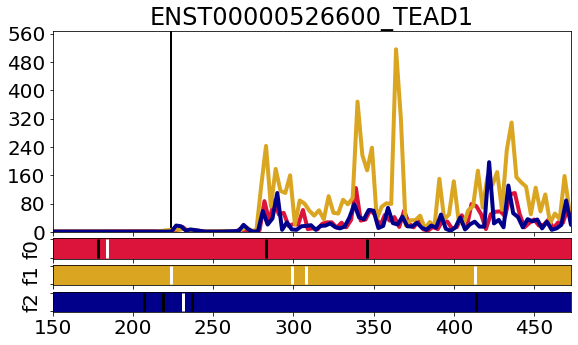

In [53]:
gene = 'TEAD1'

tr_id = 'ENST00000526600'

pre_st = False

xlims = [150, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

d1 = prepare_data_for_trips2(meta = metadata_pc_g25, 
                           file_counts = 'data/Tripslike_plots_data/%s_%s_unamb.csv' % (tr_id, gene), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id,                 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =80, 
                             fraq = 50, 
                             cds = False,
                             name = 'TEAD1.png', 
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False
                           )

trips_full_no_ORF(d1, name = 'TEAD1_mccmb.png', font1=20, font2=24)

933
NAME: ENST00000527636_TEAD1
0


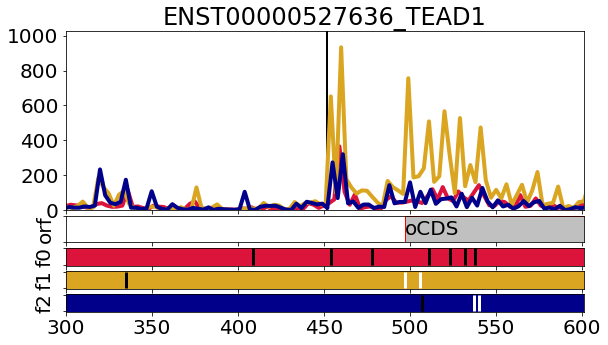

In [55]:
gene = 'TEAD1'

tr_id = 'ENST00000527636'

pre_st = '497_oCDS'

xlims = [300, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*3]

d1 = prepare_data_for_trips2(meta = metadata_pc_g25, 
                           file_counts = 'data/Tripslike_plots_data/%s_%s_unamb.csv' % (tr_id, gene), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id,                 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =200, 
                             fraq = 50, 
                             cds = False,
                             name = 'TEAD1.png', 
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False
                           )

trips_full2(d1, name = 'TEAD1_mccmb.png', font1=20, font2=24)

# Discovery of novel proteoforms using elongating ribosome profiling data 

In [100]:
with open('data/top5000_no_ovlps_g25_39_refseq_frames_un_dict.pickle', 'rb') as handle:
    out_df_frames_un = pickle.load(handle)

* peak at nonAUG, * no peak at AUG 
Z-score AUG << 1 
(height_AUG - mean(heights_exl_AUG)) / std(heights_exl_AUG)

* extension and CDS coverage ~ similar
The coverage should be uniform upstream and downstream of the annotated start measured as a ratio of footprints in NTE vs CDS, their ratio is expected to be ≥0.9.

* CDS_cov, ext_cov >= x 

In [101]:
tmp = master_df3[['tr_id1', 'Coverage_value_ext', 'CDS_ratio', 
                  'Start_codon_ext', 'Start_ext']].merge(metadata_pc_g25[['tr_id1',
                                                    'cds_start_pos', 
                                                    'cds_stop_pos',
                                                   'gene', 'tr_id'
                                                   ]], 
                                               on='tr_id1', 
                                               how='inner')

tmp[0:2]

,tr_id1,Coverage_value_ext,CDS_ratio,Start_codon_ext,Start_ext,cds_start_pos,cds_stop_pos,gene,tr_id
0,ENST00000327044,62.500000,0.172278,CTG,12,50,2300,NOC2L,ENST00000327044.6
1,ENST00000379389,53.846154,0.327240,ATC,98,151,649,ISG15,ENST00000379389.4


In [102]:
li = []

for el in tmp.to_numpy():
    tr_id1 = el[0]
    tr_id = el[-1]
    gene = el[-2]
    
    cds_start = el[-4] 
    cds_stop = el[-3]
    
    codon_start = el[4]-1 # +1?  # nonAUG start 
    codon_type = el[3] # nonAUG start sequence 
    Coverage_value_ext = el[1]
    CDS_ratio = el[2]

   
    # CDS_ratio = Coverage_ext / Coverage_CDS, >= 1? 
    if cds_start % 3 == 0:
        frame = 'Frame 1'
    elif cds_start % 3 == 1:
        frame = 'Frame 2'
    else:
        frame = 'Frame 3'
        
    cds_frame = 'Frame %s' % (frame)
    
    try:
    
        # extract counts for that frame 
        counts = out_df_frames_un[tr_id.split('.')[0]][['Position', frame]]
    
        # extract NTE -3: +6nt 
        counts_around = counts[codon_start+3:codon_start+10+3] #1st 3 positions in out_df_frames_un -3,-2,-1 for some weird reason!
    
        # -3+6 around CDS
        counts_around_CDS = counts[cds_start+1+3:cds_start+6+1+3] # 1st 3 positions in out_df_frames_un -3,-2,-1 for some weird reason!
    
        # max value 
        height_peak_value = np.max(counts_around[frame].tolist())
    
        # max value CDS peak 
        height_peak_value_cds = np.max(counts_around_CDS[frame].tolist())
    
        ###### CDS coverage without init peak #######
    
        counts_CDS_wo_init = np.sum(counts[cds_start:cds_stop][frame].tolist()) - height_peak_value_cds
        coverage_CDS_wo_init = counts_CDS_wo_init / (cds_stop - cds_start - 1) #~mean
        counts_CDS_wo_init_array = counts[cds_start:cds_stop][frame].tolist()
        counts_CDS_wo_init_array.remove(height_peak_value_cds)
    

        std_CDS_wo_init = np.std(counts_CDS_wo_init_array)
        Z_CDS_wo_init = (height_peak_value_cds - coverage_CDS_wo_init) / std_CDS_wo_init

    
        # HEIGHT OF NTE PEAK vs CDS coverage, Z-score 
        Z_NTE = (height_peak_value - coverage_CDS_wo_init) / std_CDS_wo_init
    
    
        ############### CDS ratio calculation ######################
        coverage_CDS = np.sum(counts[cds_start:cds_stop][frame].tolist()) / (cds_stop - cds_start)
    
        coverage_NTE = np.sum(counts[codon_start:cds_start][frame].tolist()) / (cds_start - codon_start)
    
    
        CDS_nte_ratio_coverage = coverage_NTE / coverage_CDS
        ############################################################
    
        #if tr_id == 'ENST00000391418.3':
    
        li.append([tr_id, gene, codon_type, codon_start, cds_start, cds_stop, cds_frame, 
               height_peak_value, height_peak_value_cds, 
              counts_CDS_wo_init, coverage_CDS_wo_init, std_CDS_wo_init, Z_CDS_wo_init,  Z_NTE, 
              CDS_ratio, CDS_nte_ratio_coverage])
        
    except Exception as e:
        print (e, tr_id, 'tr_id is not in data')
        
sole_df = pd.DataFrame(li, columns = ['tr_id', 'gene', 'codon_type', 'codon_start', 'cds_start', 'cds_stop', 
                                 'cds_frame', 'height_peak_value_nonAUG','height_peak_value_cds', 
              'counts_CDS_wo_init', 'coverage_CDS_wo_init', 'std_CDS_wo_init', 'Z_CDS_wo_init', 'Z_NTE',
                                     'CDS_ratio', 'CDS_nte_ratio_coverage'])


print (sole_df.shape[0])
sole_df[0:2]    

'ENST00000429261' ENST00000429261.2 tr_id is not in data
'ENST00000543831' ENST00000543831.5 tr_id is not in data
'ENST00000369159' ENST00000369159.2 tr_id is not in data
'ENST00000368789' ENST00000368789.1 tr_id is not in data
'ENST00000358671' ENST00000358671.9 tr_id is not in data


/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in double_scalars
/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars


'ENST00000016946' ENST00000016946.7 tr_id is not in data
'ENST00000329516' ENST00000329516.7 tr_id is not in data
'ENST00000407834' ENST00000407834.3 tr_id is not in data
'ENST00000380751' ENST00000380751.9 tr_id is not in data
'ENST00000296739' ENST00000296739.5 tr_id is not in data
'ENST00000289448' ENST00000289448.2 tr_id is not in data
'ENST00000244527' ENST00000244527.8 tr_id is not in data
'ENST00000623183' ENST00000623183.1 tr_id is not in data
'ENST00000046087' ENST00000046087.6 tr_id is not in data
'ENST00000507918' ENST00000507918.5 tr_id is not in data
'ENST00000636536' ENST00000636536.1 tr_id is not in data
'ENST00000380184' ENST00000380184.1 tr_id is not in data
'ENST00000378149' ENST00000378149.7 tr_id is not in data


/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in double_scalars


'ENST00000318666' ENST00000318666.6 tr_id is not in data
'ENST00000240691' ENST00000240691.3 tr_id is not in data
'ENST00000257867' ENST00000257867.4 tr_id is not in data
'ENST00000434815' ENST00000434815.1 tr_id is not in data
'ENST00000251303' ENST00000251303.10 tr_id is not in data
'ENST00000550538' ENST00000550538.5 tr_id is not in data
'ENST00000398664' ENST00000398664.4 tr_id is not in data
'ENST00000623042' ENST00000623042.1 tr_id is not in data
'ENST00000328886' ENST00000328886.4 tr_id is not in data
'ENST00000604834' ENST00000604834.5 tr_id is not in data
'ENST00000615050' ENST00000615050.1 tr_id is not in data
'ENST00000390661' ENST00000390661.4 tr_id is not in data
'ENST00000334109' ENST00000334109.3 tr_id is not in data
'ENST00000326165' ENST00000326165.10 tr_id is not in data
'ENST00000333843' ENST00000333843.8 tr_id is not in data
'ENST00000454971' ENST00000454971.2 tr_id is not in data
'ENST00000325321' ENST00000325321.7 tr_id is not in data
'ENST00000317643' ENST0000031

,tr_id,gene,codon_type,codon_start,cds_start,cds_stop,cds_frame,height_peak_value_nonAUG,height_peak_value_cds,counts_CDS_wo_init,coverage_CDS_wo_init,std_CDS_wo_init,Z_CDS_wo_init,Z_NTE,CDS_ratio,CDS_nte_ratio_coverage
0,ENST00000327044.6,NOC2L,CTG,11,50,2300,Frame Frame 3,1,380,17742,7.888839,44.206678,8.417533,-0.155833,0.172278,0.286520
1,ENST00000379389.4,ISG15,ATC,97,151,649,Frame Frame 2,548,2875,44294,89.122736,205.714212,13.542464,2.230654,0.327240,0.292685


# Select exclusive ones: 

* similar coverage CDS_nte_cov >= 0.9
* no peak at AUG: Z_CDS_wo_init < 1, height_peak_value_cds
* peak at nonAUG: height_peak_value_nonAUG > 10

In [103]:
SEL = sole_df[(sole_df['CDS_nte_ratio_coverage'] >= 0.9) & 
       (sole_df['Z_CDS_wo_init'] < 1) & 
        (sole_df['height_peak_value_nonAUG'] >= 10) &
        (sole_df['coverage_CDS_wo_init'] > 1)]


# (sole_df['height_peak_value_cds'] < 2) &

print (SEL.shape[0])

SEL[['gene', 'tr_id', 'codon_type', 'height_peak_value_nonAUG', 'height_peak_value_cds', 
    'coverage_CDS_wo_init']]

35


,gene,tr_id,codon_type,height_peak_value_nonAUG,height_peak_value_cds,coverage_CDS_wo_init
262,PIP5K1A,ENST00000349792.9,TTG,335,3,1.063069
285,PYGO2,ENST00000368457.2,CTG,475,13,6.003279
291,GBA,ENST00000327247.9,GTG,329,0,9.356522
299,RRNAD1,ENST00000368216.8,CTG,335,11,3.288718
302,ARHGEF11,ENST00000368194.7,AGG,39,6,2.277730
371,PHLDA3,ENST00000367311.4,CTG,104,74,26.530026
407,HLX,ENST00000366903.7,CTG,10,6,1.668486
445,TRAPPC12,ENST00000324266.9,TTG,402,27,15.145899
599,PLEKHB2,ENST00000234115.10,ATC,1482,10,52.354887
699,DNER,ENST00000341772.4,CTG,315,2,14.885224


---- manual check of each gene profile in Trips-viz ---- 

In [131]:
sel_genes = ['PIP5K1A', #
 'PYGO2', #
 'GBA', #
 'RRNAD1', #
 'ARHGEF11', #
 'TRAPPC12', #
 'PLEKHB2', #
 'DNER', #
 'STK38',#
 'SLC25A32', #
 'INSL4', #
 'ENDOG', #
 'MARVELD1', #
 'WNT5B', #
 'FBXO34', #
 'CHRNA5', #
 'MT1F', #
 'FAM117A', #
 'MIDN', #
 'THOP1', #
 'MFSD12', #
 'RFX2', #
 'KIRREL2', #
 'CCDC8', #
 'RGS19', #
 'SLC25A1'#
]

len(sel_genes)

26

# Fasta sequences 

In [134]:
li = {}

for el in master_df4[master_df4['gene'].isin(sel_genes)][['global_coo', 'tr_id', 'Start_ext', 'Stop_ext',
                                                         'N_term_start1','N_term_end1', 'gene',
                                                         'Start_codon_ext']].to_numpy():
    global_coo = el[0]
    chrom = global_coo.split(':')[0]
    tr_id = el[1]
    start = el[2] - 1
    stop = el[3]
    primary_ext = el[4]
    gene = el[-2]
    
    if tr_id == 'ENST00000395042.1':
        # downloaded 
        a = start - primary_ext + 1 + 3 # 3' in-frame STOP 
        b = start - primary_ext  + 3
        a1 = a-4
        b1 = a+3
        
        aln_col, ids = get_aln(fasta_input='data/PCSF_primary_ext_top5000/%s/fasta3/%s.fasta' % (chrom, tr_id))
        new_col_ind = re_index_with_gaps(aln_col)
        start_codon = slice_aln(aln_col, new_col_ind, a, b)
        TIS_seq = slice_aln(aln_col, new_col_ind, a1, b1)
        
    elif tr_id == 'ENST00000307522.3':
        # move start from ... ... ATC to CTG ... ..., -6
        a = start - primary_ext + 1 #- 6
        b = start - primary_ext + 3 #- 6
        a1 = a-4
        b1 = a+3
        aln_col, ids = get_aln(fasta_input='data/PCSF_primary_ext_top5000/%s/fasta3/%s.fasta' % (chrom, tr_id))
        new_col_ind = re_index_with_gaps(aln_col)
        start_codon = slice_aln(aln_col, new_col_ind, a, b)
        TIS_seq = slice_aln(aln_col, new_col_ind, a1, b1)
        
    else:
        a = start - primary_ext + 1
        b = start - primary_ext  + 3
        a1 = a-4
        b1 = a+3
        aln_col, ids = get_aln(fasta_input='data/PCSF_primary_ext_top5000/%s/fasta3/%s.fasta' % (chrom, tr_id))
        new_col_ind = re_index_with_gaps(aln_col)
        start_codon = slice_aln(aln_col, new_col_ind, a, b)
        TIS_seq = slice_aln(aln_col, new_col_ind, a1, b1)
    
    li[tr_id] = [gene, aln_col, ids, start_codon, TIS_seq]
    
    
    # check if start in genome is the same as transcriptome
    genome_codon = ''.join(start_codon[0]).replace('-', '')
    tr_codon = el[-1]
    print(tr_id, global_coo, 'tr', tr_codon, 'g', genome_codon)

ENST00000349792.9 chr1:151198955-151198996 tr TTG g TTG
ENST00000368457.2 chr1:154961577-154961705 tr CTG g CTG
ENST00000327247.9 chr1:155241113-155241180+chr1:155244506-155244506 tr GTG g GTG
ENST00000368216.8 chr1:156729045-156729104 tr CTG g CTG
ENST00000368194.7 chr1:157044331-157044363 tr AGG g AGG
ENST00000324266.9 chr2:3379824-3379876+chr2:3387620-3387623 tr TTG g TTG
ENST00000234115.10 chr2:131105359-131105398+chr2:131120934-131120941 tr ATC g ATC
ENST00000341772.4 chr2:229714424-229714456 tr CTG g CTG
ENST00000229812.7 chr6:36540203-36540207+chr6:36547190-36547250 tr CTG g CTG
ENST00000297578.8 chr8:103414938-103415075 tr TTG g TTG
ENST00000239316.4 chr9:5231485-5231523 tr AGG g AGG
ENST00000372642.4 chr9:128818550-128818684 tr TTG g TTG
ENST00000285605.7 chr10:97713829-97713876 tr ATT g ATT
ENST00000397196.6 chr12:1631316-1631354 tr CTG g CTG
ENST00000313833.4 chr14:55271494-55271537+chr14:55350381-55350390 tr CTG g CTG
ENST00000299565.9 chr15:78565639-78565719 tr GTG g GTG
E

# Discovery of novel proteoforms using initiating ribosome profiling data 

* download bigwig files from GWIPs-viz for initiating ribosome profiles 

* get global coo for non-AUG starts and CDS AUG starts 

In [137]:
def prepare_global_coo(path_to_file_with_global_coo, colname):    
    global_coo_g25 = pd.read_csv(path_to_file_with_global_coo, sep='\t')
    global_coo_g25_f = global_coo_g25[global_coo_g25['hit'] == True]
    global_coo_g25_f = global_coo_g25_f.sort_values(by=['seqnames', 'start'])
    global_coo_g25_f['global_coo'] = global_coo_g25_f['seqnames']+':'+global_coo_g25_f['start'].astype(str) +'-'+global_coo_g25_f['end'].astype(str)
    global_coo_g25_f = global_coo_g25_f[['group_name', 'strand', 'global_coo']].groupby(['group_name', 'strand']).agg('+'.join).reset_index()
    global_coo_g25_f.columns = ['tr_id', 'strand', colname]
    return global_coo_g25_f

### nonAUG starts  +-3 nt 

* get coordinates in R script; don't forget to move CCDC8 start to CUG in input file with local coordinates

In [140]:
df = pd.read_csv('tmp_res/nonAUG_plus_minus_triplet_global.txt', sep='\t')

nonAUG_global_df = prepare_global_coo(path_to_file_with_global_coo='tmp_res/nonAUG_plus_minus_triplet_global.txt', 
                                      colname='global_coo_nonAUG').merge(SEL, on='tr_id', how='inner')

### dAUG start +-3 nt 

In [143]:
df = pd.read_csv('tmp_res/AUG_plus_minus_triplet_global.txt', sep='\t')

global_df = prepare_global_coo(path_to_file_with_global_coo='tmp_res/AUG_plus_minus_triplet_global.txt', 
                                      colname='global_coo_AUG').merge(nonAUG_global_df, on=['tr_id', 'strand'], how='inner')

### 5'leader global coo (background)

In [146]:
metadata_pc_g25[metadata_pc_g25['tr_id'].isin(global_df['tr_id'].tolist())][['tr_id', 
                                                                             'utr5_start', 
                                                                             'cds_start_pos']].to_csv('tmp_res/local_5leaders.txt',
                                                                                                       sep='\t', 
                                                                                                       index=False)

In [147]:
df = pd.read_csv('tmp_res/global_5leaders.txt', sep='\t')
#df[df['hit'] == True].groupby(by='group_name').count()

global_df_all = prepare_global_coo(path_to_file_with_global_coo='tmp_res/global_5leaders.txt', 
                                      colname='global_coo_5leader').merge(global_df, on=['tr_id', 'strand'], how='inner')

In [148]:
global_df_all[['tr_id', 'gene', 'strand', 
               'global_coo_5leader', 'global_coo_AUG', 'global_coo_nonAUG']][0:5]

,tr_id,gene,strand,global_coo_5leader,global_coo_AUG,global_coo_nonAUG
0,ENST00000215882.9,SLC25A1,-,chr22:19178677-19178830,chr22:19178668-19178676,chr22:19178719-19178727
1,ENST00000229812.7,STK38,-,chr6:36540206-36540207+chr6:36547190-36547470,chr6:36540197-36540205,chr6:36547245-36547253
2,ENST00000234115.10,PLEKHB2,+,chr2:131104944-131105398+chr2:131120934-131120938,chr2:131120939-131120947,chr2:131105356-131105364
3,ENST00000239316.4,INSL4,+,chr9:5231419-5231520,chr9:5231521-5231529,chr9:5231482-5231490
4,ENST00000240364.6,FAM117A,-,chr17:49764091-49764167,chr17:49764082-49764090,chr17:49764112-49764120


* we have coordinates of non-AUG starts and dAUGs 
* check that no peaks at dAUGs (below threshold)
* check that there are peaks at dAUG (above threshold)

### Parse bigwig files 

In [149]:
!ls data/GWIPS_INIT_PROFILES

Chen20_All.RiboProInit.bw	  Gawron16_All.RiboProInit.bw
Crappe15_All.RiboProInit.bw	  Ji15_All.RiboProInit.bw
Fijalkowska17_All.RiboProInit.bw  Raj16_All.RiboProInit.bw
Gao14_All.RiboProInit.bw	  Zhang17_All.RiboProInit.bw


In [151]:
data_li = []

for el in global_df_all[['tr_id', 'gene', 'strand', 
               'global_coo_5leader', 'global_coo_AUG', 'global_coo_nonAUG']].to_numpy():
    
    
    nonAUG = []
    AUG = []
    li_5leader = []
    
    for name in glob.glob('data/GWIPS_INIT_PROFILES/*.bw'):
        
        bw = pyBigWig.open(name)
        
        tr_id = el[0]
        gene = el[1]
        
        strand = el[2]
        coo_nonAUG = el[5].split('+')
        coo_AUG = el[4].split('+')
        coo_5leader = el[3].split('+')
    
    
        # get peaks heights, nonAUG  
        li_nonAUG = []
        for coo in coo_nonAUG:
            chrom = coo.split(':')[0]
            start = int(coo.split(':')[1].split('-')[0])
            stop = int(coo.split(':')[1].split('-')[1])
            num = bw.stats(chrom, start, stop, type="max")[0]
            if num != None:
                li_nonAUG.append(num)
        
        if len(li_nonAUG) != 0:
            peak_height_nonAUG = np.max(li_nonAUG)
        else:
            peak_height_nonAUG = None
        
        
        # get peaks heights, AUG  
        li_AUG = []
        for coo in coo_AUG:
            chrom = coo.split(':')[0]
            start = int(coo.split(':')[1].split('-')[0])
            stop = int(coo.split(':')[1].split('-')[1])
            num = bw.stats(chrom, start, stop, type="max")[0]
            if num != None:
                li_AUG.append(num)
        
        if len(li_AUG) != 0:
            peak_height_AUG = np.max(li_AUG)
        else:
            peak_height_AUG = None
            
            
            
        li = []    
        # get background height in 5'leader
        for coo in coo_5leader:
            chrom = coo.split(':')[0]
            start = int(coo.split(':')[1].split('-')[0])
            stop = int(coo.split(':')[1].split('-')[1])
            if start != stop:
                num_li = bw.values(chrom, start, stop) # list of heights containing None 
                #print (gene, num_li)
                for num in num_li:       
                    if num != num:
                        li.append(0)
                    else:
                        li.append(num)
            else:
                stop = stop+1
                num_li = bw.values(chrom, start, stop) # list of heights containing None 
                #print (gene, num_li)
                for num in num_li:       
                    if num != num:
                        li.append(0)
                    else:
                        li.append(num)
                        
        # flatten list 
        #bg = (np.sum(flatten_li) - peak_height_nonAUG) / (len(flatten_li)-1)
        
        #print (name)
        #print (gene, tr_id, 'bg:%s' % flatten_li, 'nonAUG:%s' % peak_height_nonAUG, 'AUG:%s' % peak_height_AUG)
        #print ()
        
        li_5leader.append(li)
        
        
        nonAUG.append(peak_height_nonAUG)
        AUG.append(peak_height_AUG)
        
        #print (len(li_5leader))
        
    flatten_li = np.array([item for sublist in li_5leader for item in sublist])
    #flatten_li[np.isnan(flatten_li)] = 0
    
    nonAUG_height = np.sum(list(filter(None, nonAUG)))
    AUG_height = np.sum(list(filter(None, AUG)))
    
    
    diff = np.sum(flatten_li) - nonAUG_height
    diff_len = len(list(flatten_li)) - 1
    
    if diff >= 0:
        bg = diff / diff_len  #what if we measure background per codon 
    else:
        bg = 0
        
    # std, remove peak at nonAUG height  
    diff1 = []
    for el in flatten_li:
        if el != peak_height_nonAUG:
            diff1.append(el)  
    std = np.std(diff1)
    
    
    # Z score for AUG and nonAUG peak 
    nonAUG_Zscore = (nonAUG_height - std) / bg
    AUG_Zscore = (AUG_height - std) / bg
    
    
    data_li.append([tr_id, gene, nonAUG_height,  AUG_height, bg, std, nonAUG_Zscore, AUG_Zscore])
    
    
bigwig_df = pd.DataFrame(data_li, columns = ['tr_id', 'gene', 'nonAUG_height',  'AUG_height', 'bg', 'std',
                                            'nonAUG_Zscore', 'AUG_Zscore'])

bigwig_df.to_csv('data/bigwig_soleAUG_init_data_Zscore.txt', sep='\t', index=False)

bigwig_df.sort_values(by='nonAUG_Zscore')[0:4]

/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:120: RuntimeWarning: invalid value encountered in double_scalars
/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:121: RuntimeWarning: divide by zero encountered in double_scalars


,tr_id,gene,nonAUG_height,AUG_height,bg,std,nonAUG_Zscore,AUG_Zscore
17,ENST00000327247.9,GBA,0.0,11.0,0.524410,4.180215,-7.971268,13.004673
28,ENST00000368194.7,ARHGEF11,1.0,13.0,0.176421,2.108048,-6.280705,61.738447
29,ENST00000368216.8,RRNAD1,24.0,26.0,0.906131,15.312226,9.587763,11.794949
22,ENST00000349792.9,PIP5K1A,22.0,6.0,1.090523,10.343765,10.688662,-3.983193


In [152]:
sel_bg = bigwig_df[(bigwig_df['bg'] > 0) & 
          (bigwig_df['std'] > 0) & 
          (bigwig_df['nonAUG_Zscore'] > bigwig_df['AUG_Zscore']) & 
          (bigwig_df['nonAUG_Zscore'] > 5) & 
          (bigwig_df['AUG_Zscore'] <= 5)]

sel_bg.to_csv('data/SEL_by_Zscore_init_ribo.txt', sep='\t', index=False)

sel_bg.sort_values(by='nonAUG_Zscore')

,tr_id,gene,nonAUG_height,AUG_height,bg,std,nonAUG_Zscore,AUG_Zscore
22,ENST00000349792.9,PIP5K1A,22.0,6.0,1.090523,10.343765,10.688662,-3.983193
18,ENST00000332780.3,KLHDC8B,47.0,14.0,1.312692,8.341831,29.449544,4.310357
9,ENST00000297578.8,SLC25A32,417.0,45.0,7.071374,92.288296,45.919183,-6.687286
24,ENST00000359788.8,ZNF675,51.0,0.0,0.262320,1.707736,187.908948,-6.510127
19,ENST00000334350.6,MT1F,46.0,1.0,0.222723,2.197693,196.667591,-5.377510
1,ENST00000229812.7,STK38,260.0,4.0,1.066311,8.329743,236.019645,-4.060489
25,ENST00000360202.9,KIRREL2,142.0,2.0,0.462282,6.632354,292.824573,-10.020615
13,ENST00000307522.3,CCDC8,144.0,5.0,0.408508,4.071671,342.535206,2.272488
30,ENST00000368457.2,PYGO2,650.0,17.0,1.581534,20.167783,398.241369,-2.002982
32,ENST00000395042.1,RGS19,229.0,4.0,0.472076,5.805292,472.793643,-3.824153


In [153]:
', '.join(sel_bg['gene'].tolist())

'STK38, SLC25A32, CCDC8, KLHDC8B, MT1F, PIP5K1A, ZNF675, KIRREL2, PYGO2, RGS19'

# Plots of FInal novel proteoforms (CCDC8 on top of notebook)

In [154]:
# just 8 genes 
', '.join(set(sel_bg['gene'].tolist()).intersection(sel_genes))

# KIRREL2: ddAUG works, PANTs 
# PIP5K1A: ?

'SLC25A32, CCDC8, MT1F, STK38, KIRREL2, PIP5K1A, RGS19, PYGO2'

## STK38

In [127]:
gene = 'STK38'
tr_id1 = transl_with_all_codons2[transl_with_all_codons2['gene'] == gene].iloc[0].tr_id1
tr_id = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id1)].iloc[0].tr_id


print (tr_id)

tr_seq = metadata_pc_g25[metadata_pc_g25['tr_id'] == tr_id].iloc[0].transcript_seq
cds_start_pos = metadata_pc_g25[metadata_pc_g25['tr_id'] == tr_id].iloc[0].cds_start_pos
cds_stop_pos = metadata_pc_g25[metadata_pc_g25['tr_id'] == tr_id].iloc[0].cds_stop_pos

NTE_start = SEL[SEL['tr_id'].str.contains(tr_id1)].iloc[0].codon_start
NTE_stop = SEL[SEL['tr_id'].str.contains(tr_id1)].iloc[0].cds_start
TIS_seq = tr_seq[NTE_start-4:NTE_start+4].replace("T", 'U')

print ('cds_start:', cds_start_pos, 'cds_stop:', cds_stop_pos)
print ('NTE_start:', NTE_start, 'NTE_stop:', NTE_stop)

print ('TIS sequence:', TIS_seq)
print ('TIS score:', TIS_efficiency_df[TIS_efficiency_df['TIS Sequence'] == TIS_seq].iloc[0]['TIS Efficiency'])

print ('NTE aa sequence:', str(Seq(tr_seq[NTE_start-1:NTE_stop+2]).translate()))

ENST00000229812.7
cds_start: 286 cds_stop: 1684
NTE_start: 220 NTE_stop: 286
TIS sequence: ACUACUGG
TIS score: 7.7
NTE aa sequence: TGRRGVCGSPPSPALPLPGLCSH


STK38
1776
NAME: ENST00000229812_STK38
0


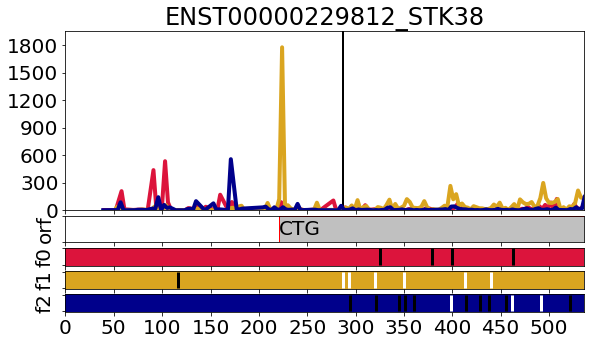

In [130]:
gene = 'STK38'

tr_id = 'ENST00000229812'


pred_start = master_df2[master_df2['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = master_df2[master_df2['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 

print (gene)

pre_st = pos_pred_start + '_' + pred_start

#pre_st = '336_UUG'

xlims = [0, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

d1 = prepare_data_for_trips2(meta = metadata_pc_g25, 
                           file_counts = 'data/Tripslike_plots_data/STK38_ENST00000229812_unamb.csv', 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id,                 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =300, 
                             fraq = 50, 
                             cds = False,
                             name = 'STK38.png', 
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False
                           )

trips_full2(d1, name = 'STK38.png', font1=20, font2=24)

## SLC25A1	

In [124]:
gene = 'SLC25A1'
tr_id1 = 'ENST00000297578'#transl_with_all_codons2[transl_with_all_codons2['gene'] == gene].iloc[0].tr_id1
tr_id = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id1)].iloc[0].tr_id


print (tr_id)

tr_seq = metadata_pc_g25[metadata_pc_g25['tr_id'] == tr_id].iloc[0].transcript_seq
cds_start_pos = metadata_pc_g25[metadata_pc_g25['tr_id'] == tr_id].iloc[0].cds_start_pos
cds_stop_pos = metadata_pc_g25[metadata_pc_g25['tr_id'] == tr_id].iloc[0].cds_stop_pos

NTE_start = SEL[SEL['tr_id'].str.contains(tr_id1)].iloc[0].codon_start
NTE_stop = SEL[SEL['tr_id'].str.contains(tr_id1)].iloc[0].cds_start
TIS_seq = tr_seq[NTE_start-4:NTE_start+4].replace("T", 'U')

print ('cds_start:', cds_start_pos, 'cds_stop:', cds_stop_pos)
print ('NTE_start:', NTE_start, 'NTE_stop:', NTE_stop)

print ('TIS sequence:', TIS_seq)
print ('TIS score:', TIS_efficiency_df[TIS_efficiency_df['TIS Sequence'] == TIS_seq].iloc[0]['TIS Efficiency'])

print ('NTE aa sequence:', str(Seq(tr_seq[NTE_start-1:NTE_stop+2]).translate()))

ENST00000297578.8
cds_start: 167 cds_stop: 1115
NTE_start: 29 NTE_stop: 167
TIS sequence: CGCCUUGG
TIS score: 5.1
NTE aa sequence: LGHKSPLVGPGGGVALTRGDRRHGGGHCIASHLRGPGRRGVDGPRAY


SLC25A1
2579
NAME: ENST00000297578_SLC25A1
0


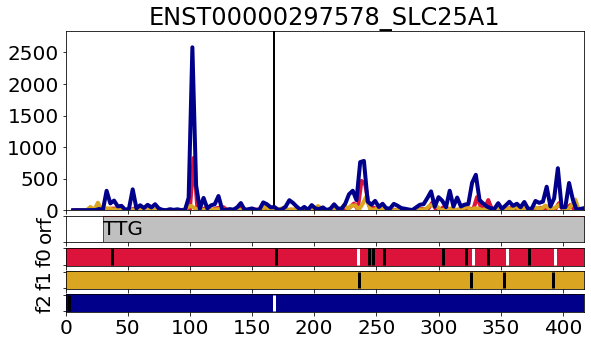

In [126]:
gene = 'SLC25A1'

tr_id = 'ENST00000297578'


pred_start = master_df2[master_df2['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = master_df2[master_df2['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 

print (gene)

pre_st = pos_pred_start + '_' + pred_start

#pre_st = '336_UUG'

xlims = [0, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

d1 = prepare_data_for_trips2(meta = metadata_pc_g25, 
                           file_counts = 'data/Tripslike_plots_data/SLC25A32_ENST00000297578_unamb.csv', 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id,                 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =500, 
                             fraq = 50, 
                             cds = False,
                             name = 'SLC25A1.png', 
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False
                           )

trips_full2(d1, name = 'ENST00000334350_mccmb.png', font1=20, font2=24)

## MIDN

In [75]:
gene = 'MIDN'
tr_id1 = transl_with_all_codons2[transl_with_all_codons2['gene'] == gene].iloc[0].tr_id1
tr_id = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id1)].iloc[0].tr_id


print (tr_id)

tr_seq = metadata_pc_g25[metadata_pc_g25['tr_id'] == tr_id].iloc[0].transcript_seq
cds_start_pos = metadata_pc_g25[metadata_pc_g25['tr_id'] == tr_id].iloc[0].cds_start_pos
cds_stop_pos = metadata_pc_g25[metadata_pc_g25['tr_id'] == tr_id].iloc[0].cds_stop_pos

NTE_start = transl_with_all_codons2[transl_with_all_codons2['gene'] == 'MIDN'].iloc[0].Start_ext
NTE_stop = transl_with_all_codons2[transl_with_all_codons2['gene'] == 'MIDN'].iloc[0].Stop_ext
TIS_seq = tr_seq[NTE_start-5:NTE_start+3].replace("T", 'U')

print ('cds_start:', cds_start_pos, 'cds_stop:', cds_stop_pos)
print ('NTE_start:', NTE_start, 'NTE_stop:', NTE_stop)

print ('TIS sequence:', TIS_seq)
print ('TIS score:', TIS_efficiency_df[TIS_efficiency_df['TIS Sequence'] == TIS_seq].iloc[0]['TIS Efficiency'])

print ('NTE aa sequence:', str(Seq(tr_seq[NTE_start-1:NTE_stop+2]).translate()))

ENST00000300952.6
cds_start: 515 cds_stop: 1922
NTE_start: 342 NTE_stop: 516
TIS sequence: GAUUUUGG
TIS score: 1.5
NTE aa sequence: LDFGLAFRGRDFLEEDARCSAPPSARRTRHPGSLSPLSRRRGEDWRRPPPPAPQRAPGM


## MT1F

In [77]:
gene = 'MT1F'
tr_id1 = transl_with_all_codons2[transl_with_all_codons2['gene'] == gene].iloc[0].tr_id1
tr_id = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id1)].iloc[0].tr_id


print (tr_id)

tr_seq = metadata_pc_g25[metadata_pc_g25['tr_id'] == tr_id].iloc[0].transcript_seq
cds_start_pos = metadata_pc_g25[metadata_pc_g25['tr_id'] == tr_id].iloc[0].cds_start_pos
cds_stop_pos = metadata_pc_g25[metadata_pc_g25['tr_id'] == tr_id].iloc[0].cds_stop_pos

NTE_start = transl_with_all_codons2[transl_with_all_codons2['gene'] == gene].iloc[0].Start_ext
NTE_stop = transl_with_all_codons2[transl_with_all_codons2['gene'] == gene].iloc[0].Stop_ext
TIS_seq = tr_seq[NTE_start-5:NTE_start+3].replace("T", 'U')

print ('cds_start:', cds_start_pos, 'cds_stop:', cds_stop_pos)
print ('NTE_start:', NTE_start, 'NTE_stop:', NTE_stop)

print ('TIS sequence:', TIS_seq)
print ('TIS score:', TIS_efficiency_df[TIS_efficiency_df['TIS Sequence'] == TIS_seq].iloc[0]['TIS Efficiency'])

print ('NTE aa sequence:', str(Seq(tr_seq[NTE_start-1:NTE_stop+2]).translate()))

ENST00000334350.6
cds_start: 365 cds_stop: 551
NTE_start: 336 NTE_stop: 366
TIS sequence: UCUCUUGG
TIS score: 0.3
NTE aa sequence: LESPVSPRLAM


858
NAME: ENST00000334350_MT1F
0


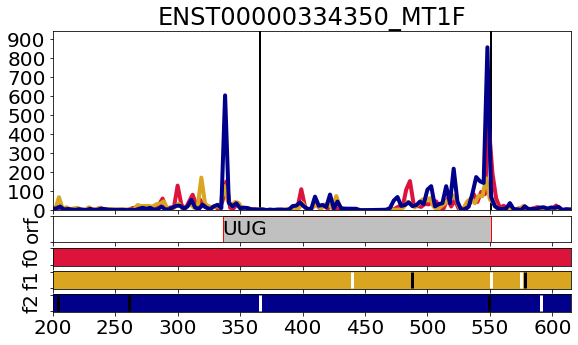

In [79]:
gene = 'MT1F'

tr_id = 'ENST00000334350'

pre_st = '336_UUG'

xlims = [200, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

d1 = prepare_data_for_trips2(meta = metadata_pc_g25, 
                           file_counts = 'data/Tripslike_plots_data/MT1F_2.csv', 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id,                 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =100, 
                             fraq = 50, 
                             cds = False,
                             name = 'TEAD1.png', 
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False
                           )

trips_full2(d1, name = 'ENST00000334350_mccmb.png', font1=20, font2=24)

## RGS19

In [95]:
gene = 'RGS19'
tr_id1 = transl_with_all_codons2[transl_with_all_codons2['gene'] == gene].iloc[0].tr_id1
tr_id = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id1)].iloc[0].tr_id


print (tr_id)

tr_seq = metadata_pc_g25[metadata_pc_g25['tr_id'] == tr_id].iloc[0].transcript_seq
cds_start_pos = metadata_pc_g25[metadata_pc_g25['tr_id'] == tr_id].iloc[0].cds_start_pos
cds_stop_pos = metadata_pc_g25[metadata_pc_g25['tr_id'] == tr_id].iloc[0].cds_stop_pos

NTE_start = transl_with_all_codons2[transl_with_all_codons2['gene'] == gene].iloc[0].Start_ext
NTE_stop = transl_with_all_codons2[transl_with_all_codons2['gene'] == gene].iloc[0].Stop_ext
TIS_AUG = tr_seq[cds_start_pos-6:cds_start_pos+5].replace("T", 'U')
TIS_seq = tr_seq[NTE_start-5:NTE_start+3].replace("T", 'U')

print ('cds_start:', cds_start_pos, 'cds_stop:', cds_stop_pos)
print ('NTE_start:', NTE_start, 'NTE_stop:', NTE_stop)

print ('TIS sequence:', TIS_seq)
print ('TIS score:', TIS_efficiency_df[TIS_efficiency_df['TIS Sequence'] == TIS_seq].iloc[0]['TIS Efficiency'])

print ('NTE aa sequence:', str(Seq(tr_seq[NTE_start-1:NTE_stop+2]).translate()))

print ('-----')
print ('TIS of cdsAUG:', TIS_AUG, TIS_AUG_eff[TIS_AUG_eff['sequence'] == TIS_AUG].iloc[0].efficiency)

ENST00000395042.1
cds_start: 267 cds_stop: 921
NTE_start: 229 NTE_stop: 268
TIS sequence: AGAGCUGG
TIS score: 30.0
NTE aa sequence: LVPRSLGNLLRPPM
-----
TIS of cdsAUG: CCACCCAUGCC 68


1349
NAME: ENST00000395042_RGS19
0


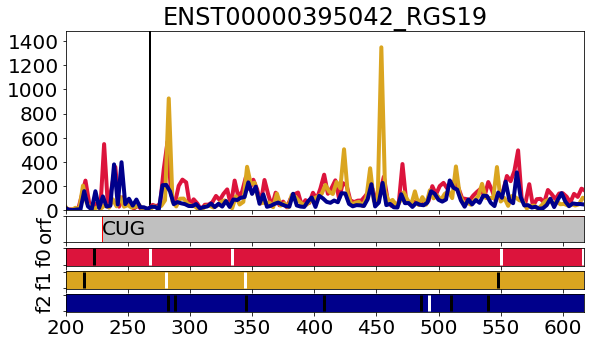

In [85]:
gene = 'RGS19'

tr_id = 'ENST00000395042'

pre_st = '229_CUG'

xlims = [200, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*7]

d1 = prepare_data_for_trips2(meta = metadata_pc_g25, 
                           file_counts = 'data/Tripslike_plots_data/RGS19.csv', 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id,                 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =200, 
                             fraq = 50, 
                             cds = False,
                             name = 'TEAD1.png', 
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False
                           )

trips_full2(d1, name = 'ENST00000334350_mccmb.png', font1=20, font2=24)

# TIS scores barplot 

In [96]:
li = [['EIF4G2', 8.7], 
      ['TRPV6', 4.1],  
      ['STK38', 7.7],
      ['PYGO2', 0.4],
      ['CCDC8', 42.2],
      ['GTF3A', 50.4],
      ['SLC25A32\nUUG', 5.1],
      ['SLC25A32\nGUG', 1.8],
      ['RSG19', 30.0],
      ['MT1F', 0.3]]


tis_barplot = pd.DataFrame(li, columns = ['gene_start', 'TIS score']).sort_values(by='TIS score')
tis_barplot[0:4]

,gene_start,TIS score
9,MT1F,0.3
3,PYGO2,0.4
7,SLC25A32\nGUG,1.8
1,TRPV6,4.1


[Text(0, 0, '0'),
 Text(0, 10, '10'),
 Text(0, 20, '20'),
 Text(0, 30, '30'),
 Text(0, 40, '40'),
 Text(0, 50, '50')]

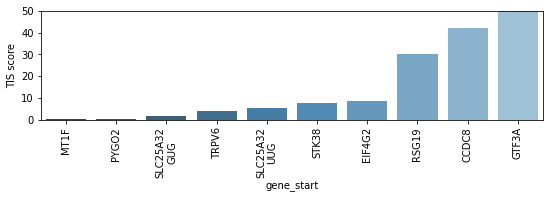

In [97]:
ax, fig = plt.subplots(1, figsize=(9, 2))


plt.rcParams['font.size'] = '17'

ax = sns.barplot(x="gene_start", y="TIS score", data=tis_barplot, palette="Blues_d")

plt.xticks(rotation = 90) 

ax.set_ylim(0, 50)

ax.set_yticks([0, 10, 20, 30, 40, 50])
ax.set_yticklabels([0, 10, 20, 30, 40, 50])

In [159]:
master_df4[master_df4['gene'].isin(['SLC25A32', 'CCDC8', 'MT1F', 'STK38', 
                                    'KIRREL2', 'PIP5K1A', 'RGS19', 'PYGO2'])].to_csv('data/SEL_genes_META.txt',
                                                                                     sep='\t', 
                                                                                     index=False)